In [1]:
!pip install tensorflow --upgrade
!yes | apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 51.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 59.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 65.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
    

In [2]:
import numpy as np
import os
import random
import PIL
import tensorflow as tf
import cv2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
import keras.backend as K
tfk = tf.keras
tfkl = tf.keras.layers

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import time
import datetime
import multiprocessing

import warnings
import logging

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

f

In [3]:
data_dir = '/kaggle/input/preprocessed-datatset'

In [4]:
# seed fixed for reproducibility

presentDate = datetime.datetime.now()
unix_timestamp = round(datetime.datetime.timestamp(presentDate))

seed = unix_timestamp
print(f'Seed: {seed}')

seed = 1673212175

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

Seed: 1674916153


In [5]:
training_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Data Loading

In [6]:
labels = ['N','P','T']

In [7]:
batch_size = 64

img_height = 256
img_width = 256

input_shape = (256, 256, 1)
classes = 3

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  training_dir,
  label_mode='categorical',
  seed=seed,
  color_mode='grayscale',
  image_size=(img_height, img_width),
  batch_size=batch_size )

val_ds = tf.keras.utils.image_dataset_from_directory(
  validation_dir,
  label_mode='categorical',
  seed=seed,
  color_mode='grayscale',
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  label_mode='categorical',
  seed=seed,
  color_mode='grayscale',
  image_size=(img_height, img_width),
  batch_size=1)

Found 10834 files belonging to 3 classes.
Found 2327 files belonging to 3 classes.
Found 2309 files belonging to 3 classes.


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data Exploration

In [10]:
y_train = np.concatenate([y for x, y in train_ds], axis=0)
_, counts = np.unique(np.argmax(y_train, axis=-1), return_counts=True)
counts

array([6542, 2981, 1311])

In [11]:
class_weights = {}
for i in range(3):
    class_weights[i] = counts.sum()/(counts[i]*3)
class_weights

{0: 0.5520228268623255, 1: 1.211450296321145, 2: 2.754640223747775}

# Model definition

In [13]:
model = tfk.Sequential([
  tfkl.Rescaling(1./255, input_shape=input_shape),
    
  tfkl.Conv2D(16, 3, padding='same', kernel_initializer=tfk.initializers.HeUniform(seed)),
  tfkl.BatchNormalization(),
  tfkl.Activation('relu'),
  tfkl.MaxPooling2D(),
    
  tfkl.Conv2D(32, 3, padding='same', kernel_initializer=tfk.initializers.HeUniform(seed)),
  tfkl.BatchNormalization(),
  tfkl.Activation('relu'),
  tfkl.MaxPooling2D(),
    
  tfkl.Conv2D(64, 3, padding='same', kernel_initializer=tfk.initializers.HeUniform(seed)),
  tfkl.BatchNormalization(),
  tfkl.Activation('relu'),
  tfkl.MaxPooling2D(),
  
  tfkl.Conv2D(128, 3, padding='same', kernel_initializer=tfk.initializers.HeUniform(seed)),
  tfkl.BatchNormalization(),
  tfkl.Activation('relu'),
  tfkl.MaxPooling2D(),
  
  tfkl.Conv2D(256, 3, padding='same', kernel_initializer=tfk.initializers.HeUniform(seed)),
  tfkl.BatchNormalization(),
  tfkl.Activation('relu'),
  tfkl.MaxPooling2D(),
    
  tfkl.Conv2D(512, 3, padding='same', kernel_initializer=tfk.initializers.HeUniform(seed)),
  tfkl.BatchNormalization(),
  tfkl.Activation('relu'),
  tfkl.GlobalMaxPooling2D(),
    
  tfkl.Dense(128, activation='relu', kernel_initializer=tfk.initializers.HeUniform(seed)),
  tfkl.Dropout(0.5),
  tfkl.Dense(3, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed))
])

In [14]:
def f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [15]:
model.compile(optimizer=tfk.optimizers.Adam(3e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision'), f1]
             )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 256, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4

In [16]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=100,
  class_weight=class_weights,
  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_f1', patience=15, restore_best_weights=True, mode='max'),
               tf.keras.callbacks.ReduceLROnPlateau(monitor='val_f1', patient=10, factor=0.1, verbose=1, mode='max')]
).history

Epoch 1/100
170/170 [==============================] - 37s 157ms/step - loss: 0.6446 - accuracy: 0.6984 - recall: 0.6628 - precision: 0.7178 - f1: 0.6875 - val_loss: 0.6698 - val_accuracy: 0.6446 - val_recall: 0.5539 - val_precision: 0.6696 - val_f1: 0.6049 - lr: 3.0000e-04
Epoch 2/100
170/170 [==============================] - 19s 110ms/step - loss: 0.3478 - accuracy: 0.8355 - recall: 0.8228 - precision: 0.8452 - f1: 0.8326 - val_loss: 0.4041 - val_accuracy: 0.8088 - val_recall: 0.7985 - val_precision: 0.8178 - val_f1: 0.8068 - lr: 3.0000e-04
Epoch 3/100
170/170 [==============================] - 19s 110ms/step - loss: 0.2609 - accuracy: 0.8852 - recall: 0.8788 - precision: 0.8921 - f1: 0.8852 - val_loss: 0.4575 - val_accuracy: 0.7860 - val_recall: 0.7821 - val_precision: 0.7889 - val_f1: 0.7846 - lr: 3.0000e-04
Epoch 4/100
170/170 [==============================] - 19s 111ms/step - loss: 0.2068 - accuracy: 0.9085 - recall: 0.9046 - precision: 0.9118 - f1: 0.9080 - val_loss: 0.2311 - 

# Evaluation

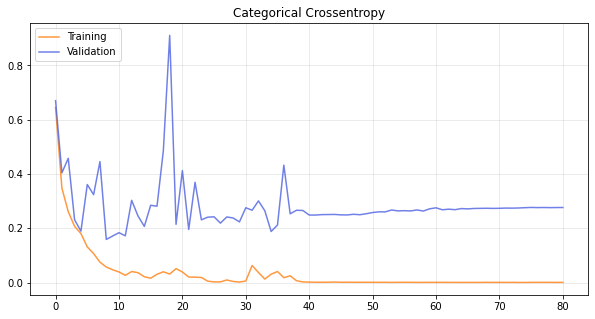

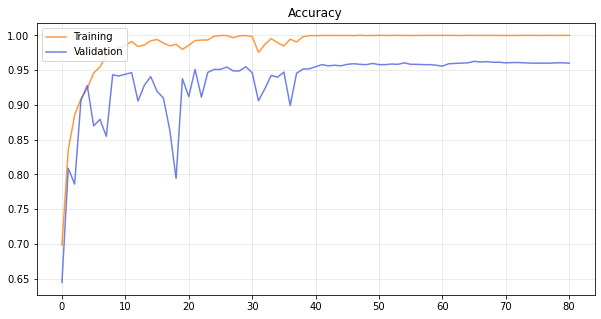

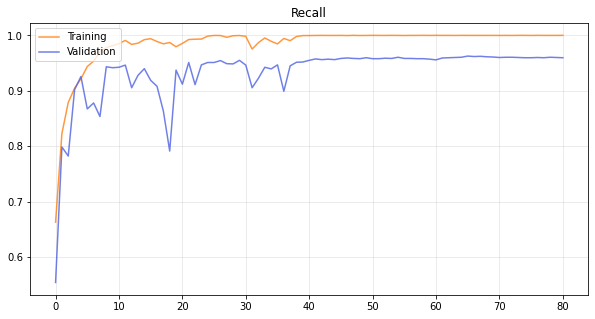

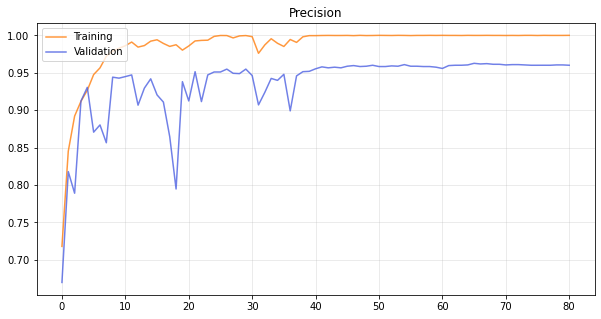

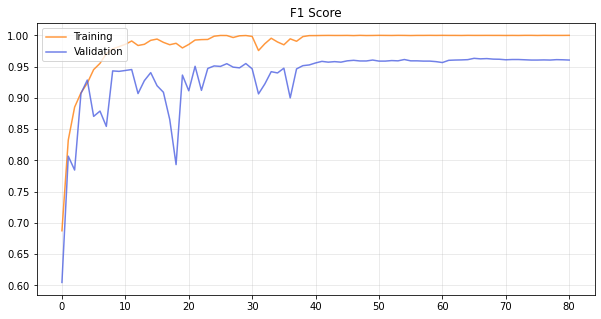

In [17]:
# Plot the training

# loss
plt.figure(figsize=(10,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

# Accuracy
plt.figure(figsize=(10,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

# Recall
plt.figure(figsize=(10,5))
plt.plot(history['recall'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_recall'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Recall')
plt.grid(alpha=.3)

# Precision
plt.figure(figsize=(10,5))
plt.plot(history['precision'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_precision'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Precision')
plt.grid(alpha=.3)

# F1
plt.figure(figsize=(10,5))
plt.plot(history['f1'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_f1'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('F1 Score')
plt.grid(alpha=.3)
plt.show()

In [18]:
model.evaluate(val_ds)

37/37 [==============================] - 1s 34ms/step - loss: 0.2713 - accuracy: 0.9626 - recall: 0.9626 - precision: 0.9626 - f1: 0.9633


[0.2712525427341461,
 0.9626128077507019,
 0.9626128077507019,
 0.9626128077507019,
 0.9632601141929626]

In [19]:
val_predictions = model.predict(val_ds)

37/37 [==============================] - 1s 31ms/step


In [24]:
def print_evaluation(y_true, predictions):
    cm = confusion_matrix(y_true, predictions, normalize='pred')
    cm_display = ConfusionMatrixDisplay(cm, display_labels = ['N', 'P', 'T'])
    cm_display.plot()
    
    print(classification_report(y_true, predictions, digits=4))

In [25]:
y_val = np.concatenate([y for x, y in val_ds], axis=0)
y_val.shape

(2327, 3)

              precision    recall  f1-score   support

           0     0.9684    0.9711    0.9698      1420
           1     0.9766    0.9843    0.9804       635
           2     0.8973    0.8676    0.8822       272

    accuracy                         0.9626      2327
   macro avg     0.9474    0.9410    0.9441      2327
weighted avg     0.9623    0.9626    0.9624      2327



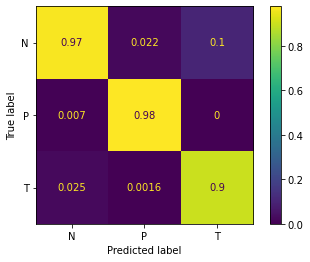

In [26]:
print_evaluation(np.argmax(y_val, axis=-1), np.argmax(val_predictions, axis=-1))

In [23]:
model.save('/kaggle/working')